## Library

In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from rembg import remove
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Load Data

In [3]:
def load(folders, max_images_per_class=100):
    images = []
    labels = []
    count = {}
    
    for folder_path in folders:
        folder_name = os.path.basename(folder_path)
        count[folder_name] = 0
        
        for filename in tqdm(os.listdir(folder_path)):
            if count[folder_name] >= max_images_per_class:
                break
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = remove(img)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (150, 150))
                images.append(img)
                labels.append(folder_name)
                count[folder_name] += 1
    
    return images, labels, count 

folders = ['monarch', 'pipevine_swallow', 'straited_queen']
images, labels, count = load(folders)

100%|██████████| 100/100 [06:29<00:00,  3.89s/it]


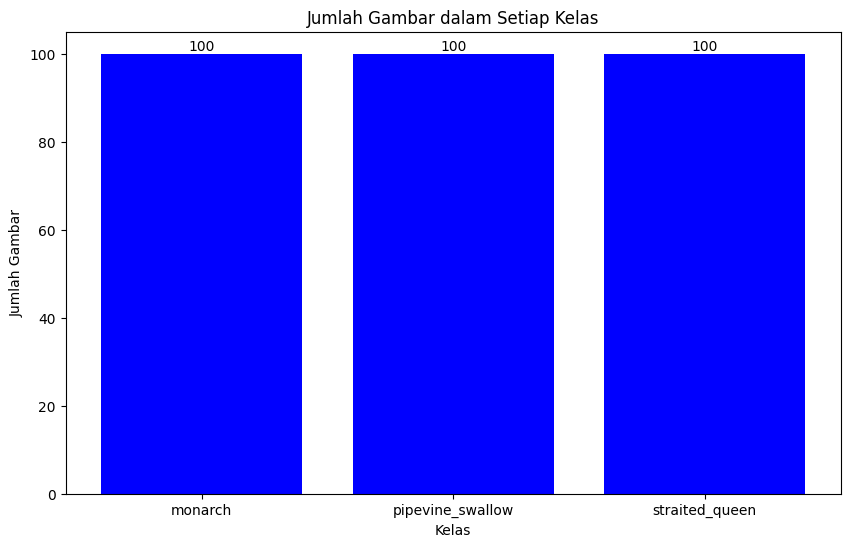

In [4]:
plt.figure(figsize=(10, 6))
bars = plt.bar(count.keys(), count.values(), color='blue')
plt.title('Jumlah Gambar dalam Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height),
             ha='center', va='bottom', fontsize=10)
plt.show()

## Normalisasi

In [5]:
def normalize_image(images):
    normalized_images = []
    for img in images:
        min_val = np.min(img)
        max_val = np.max(img)
        if min_val < 0 or max_val > 255:
            img = np.clip(img, 0, 255) 
        normalized_img = ((img - np.min(img)) / (np.max(img) - np.min(img))) * 255
        normalized_images.append(normalized_img.astype(np.uint8))
    return normalized_images


In [6]:
norm_f1 = normalize_image([img for img, label in zip(images, labels) if label == 'monarch'])
norm_f2 = normalize_image([img for img, label in zip(images, labels) if label == 'pipevine_swallow'])
norm_f3 = normalize_image([img for img, label in zip(images, labels) if label == 'straited_queen'])

In [7]:
def plot_tampilan(images, title_prefix):
    plt.figure(figsize=(16, 8))
    for i in range(min(len(images), 6)):
        plt.subplot(1, 6, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{title_prefix} Aug {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

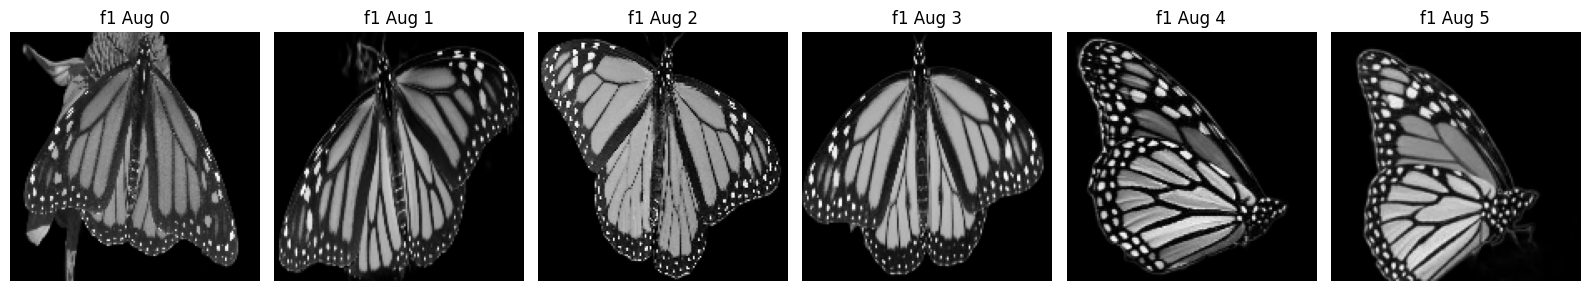

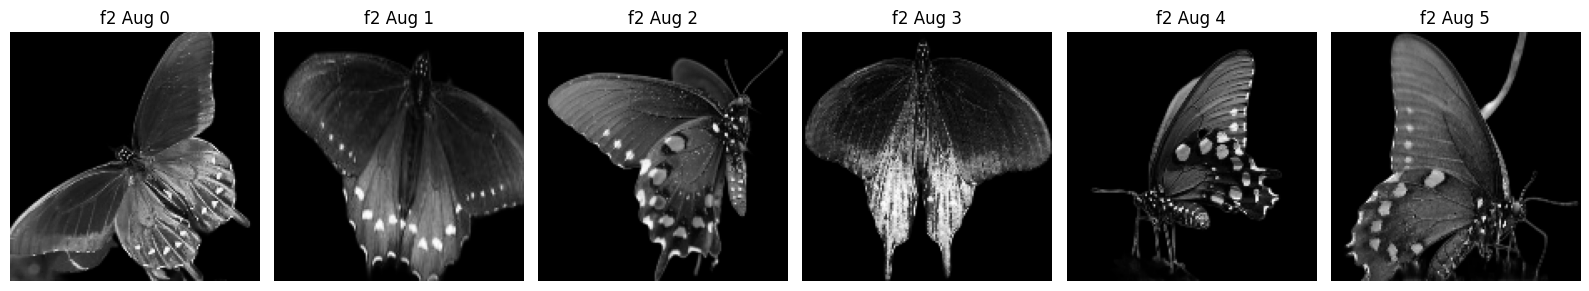

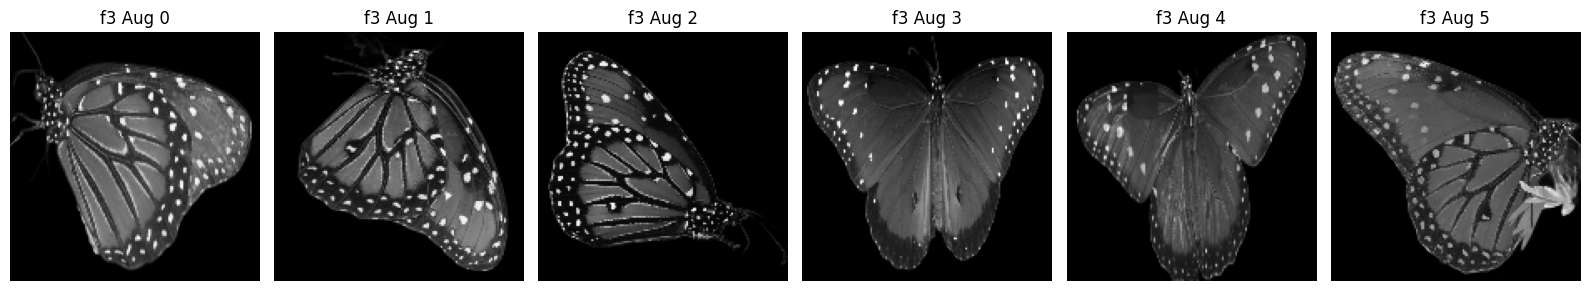

In [8]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## Ekualisasi Histogram

In [9]:
def histogram_equalization(img):
    histogram = np.zeros(256, dtype=int)
    for pixel_value in np.nditer(img):
        histogram[pixel_value] += 1
    
    cdf = np.zeros(256, dtype=int)
    cdf[0] = histogram[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + histogram[i]
    cdf_normalized = ((cdf - cdf.min()) * 255) // (cdf.max() - cdf.min())
    
    equalized_img = cdf_normalized[img]
    return equalized_img

In [10]:
norm_f1 = [histogram_equalization(img) for img in norm_f1]
norm_f2 = [histogram_equalization(img) for img in norm_f2]
norm_f3 = [histogram_equalization(img) for img in norm_f3]

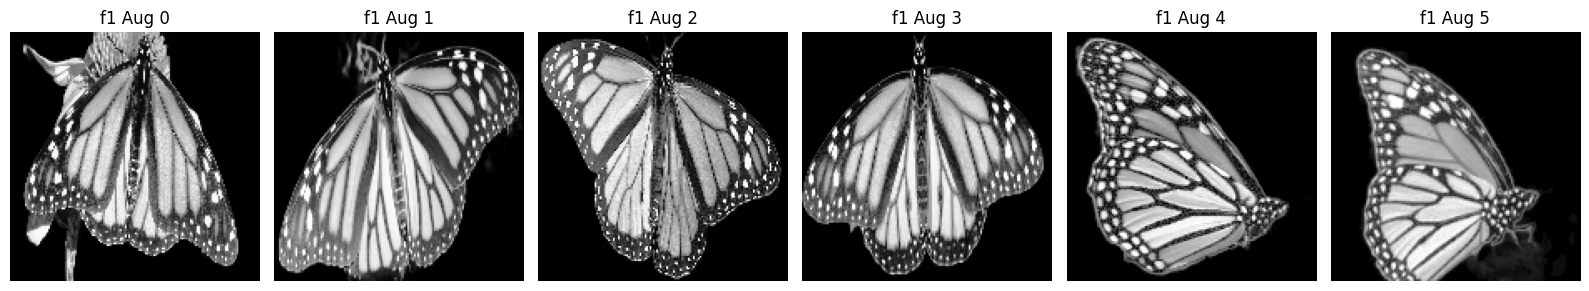

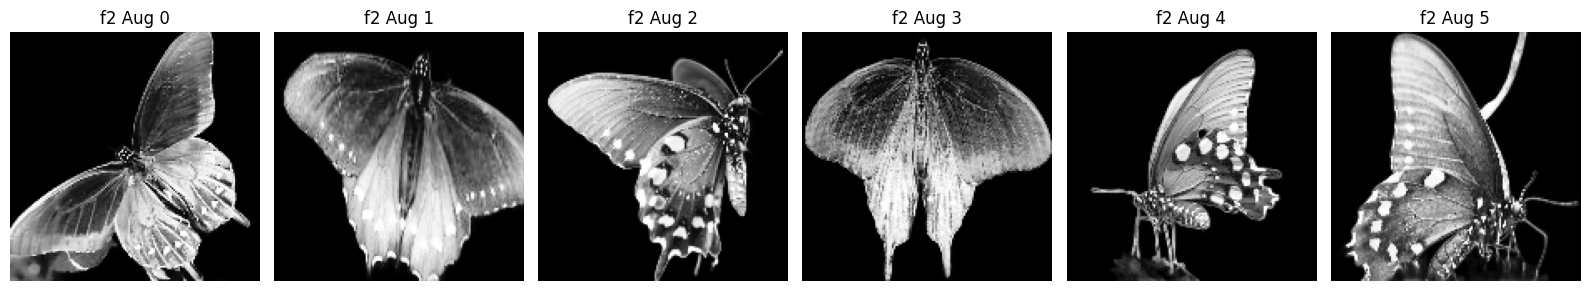

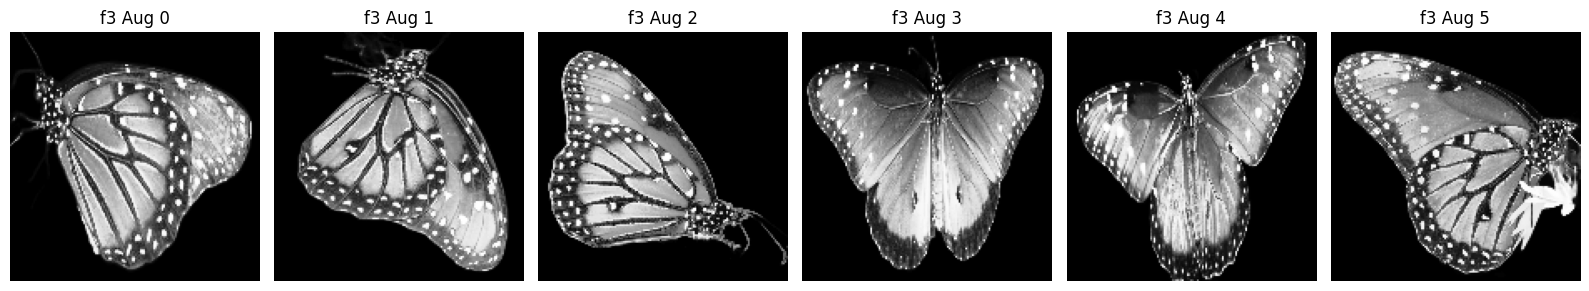

In [11]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## Threshold

In [12]:
def threshold(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] <= 127:
                image[i][j] = 255
            else: 
                image[i][j] = 0
    return image

In [13]:
norm_f1 = [threshold(img) for img in norm_f1]
norm_f2 = [threshold(img) for img in norm_f2]
norm_f3 = [threshold(img) for img in norm_f3]

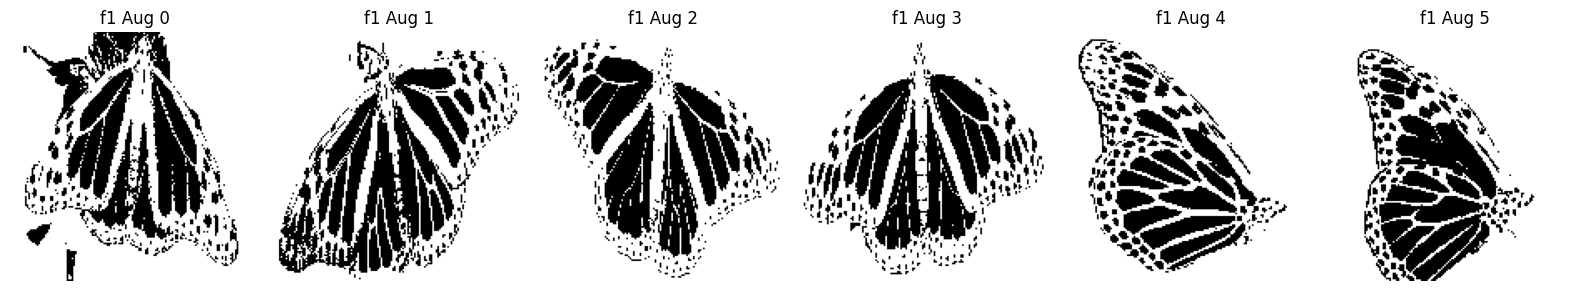

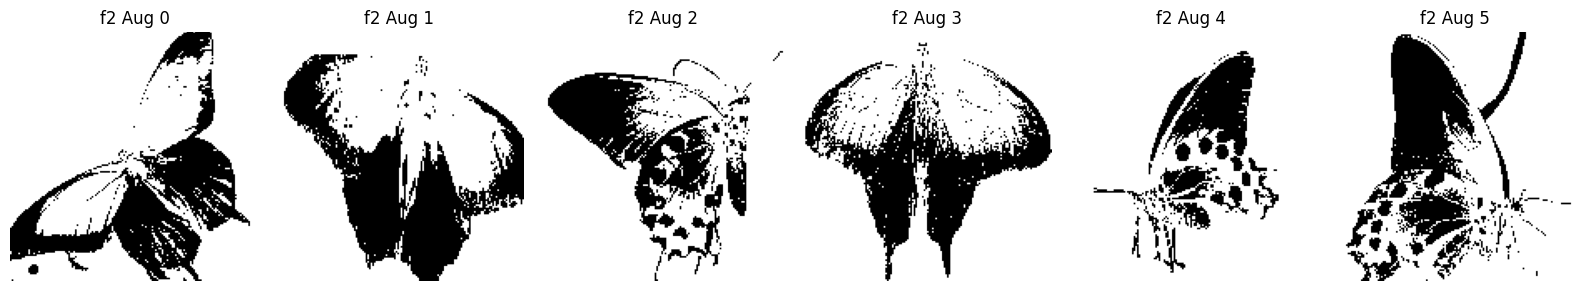

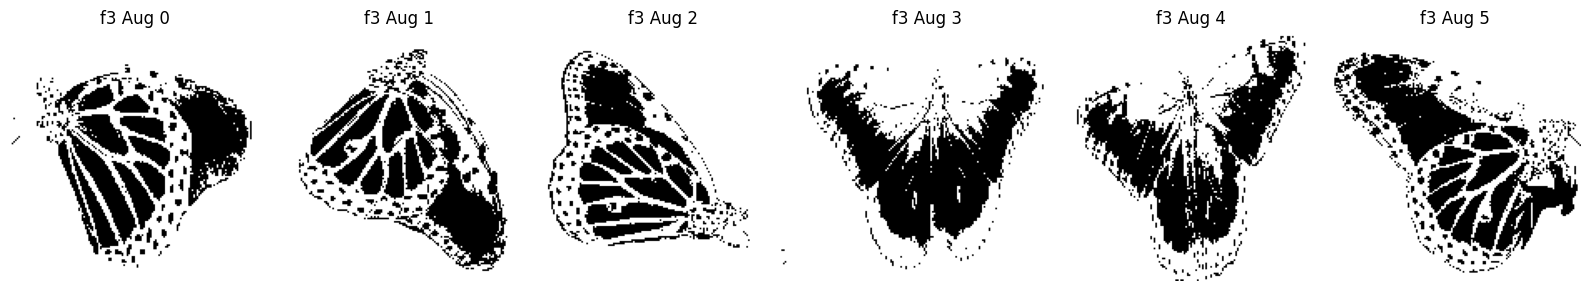

In [14]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## Mean Filter

In [15]:
def meanFilter(image):
    heightImage, widthImage = image.shape
    padImage = np.pad(image, (1,1), mode='edge')
    kernel = np.zeros((3,3))
    result = np.zeros([heightImage, widthImage]).astype(int)
    for i in range(heightImage):
        for j in range(widthImage):
            temp = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    temp += padImage[i+k, j+l]
            result[i, j] = int(temp/(kernel.shape[0]*kernel.shape[1]))
    return result

In [16]:
norm_f1 = [meanFilter(img) for img in norm_f1]
norm_f2 = [meanFilter(img) for img in norm_f2]
norm_f3 = [meanFilter(img) for img in norm_f3]

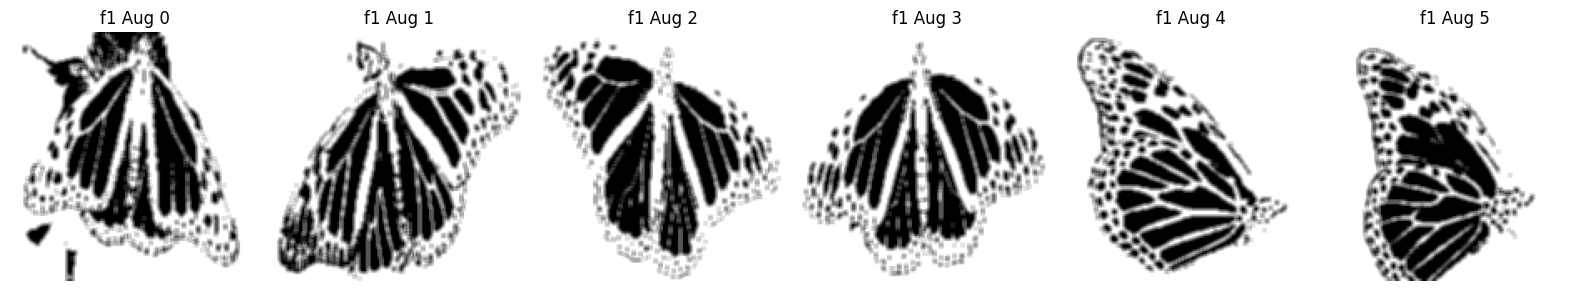

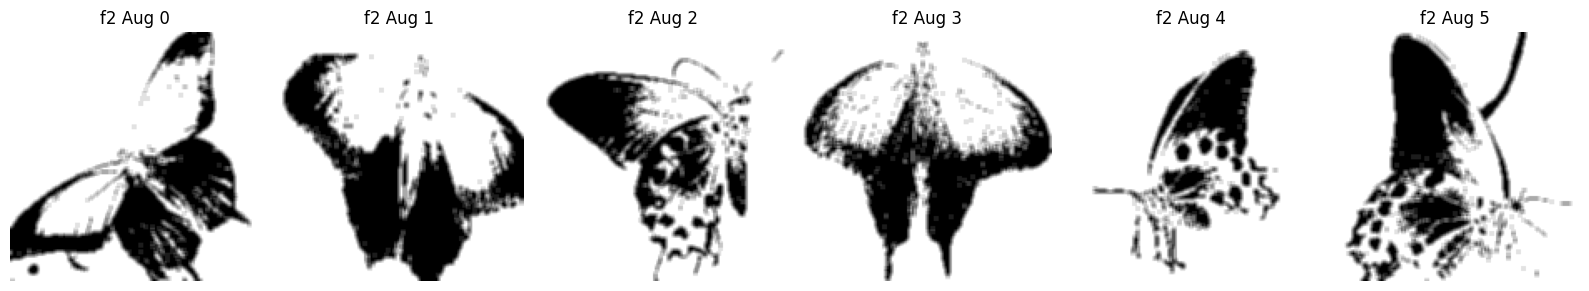

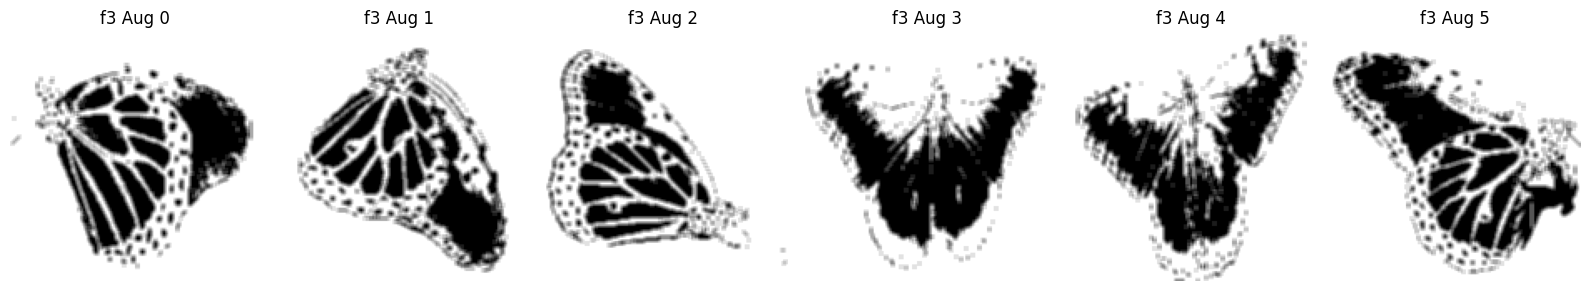

In [17]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## Prewitt

In [18]:
def konvolusi_gradient(img, kernel):
    hImg, wImg = img.shape
    hKernel, wKernel = kernel.shape

    pad_height = hKernel // 2
    pad_width = wKernel // 2

    pad_img = np.pad(img.astype(int), pad_width=((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    result = np.zeros_like(img, dtype=int)
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            sum = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    sum += pad_img[i+k, j+l] * kernel[k, l]
            result[i, j] = sum
    return result

In [19]:
def prewitt(img):
    gx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    gy = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

    x = konvolusi_gradient(img, gx)
    y = konvolusi_gradient(img, gy)

    magnitude = abs(x) + abs(y)

    return magnitude

In [20]:
norm_f1 = [prewitt(img) for img in norm_f1]
norm_f2 = [prewitt(img) for img in norm_f2]
norm_f3 = [prewitt(img) for img in norm_f3]

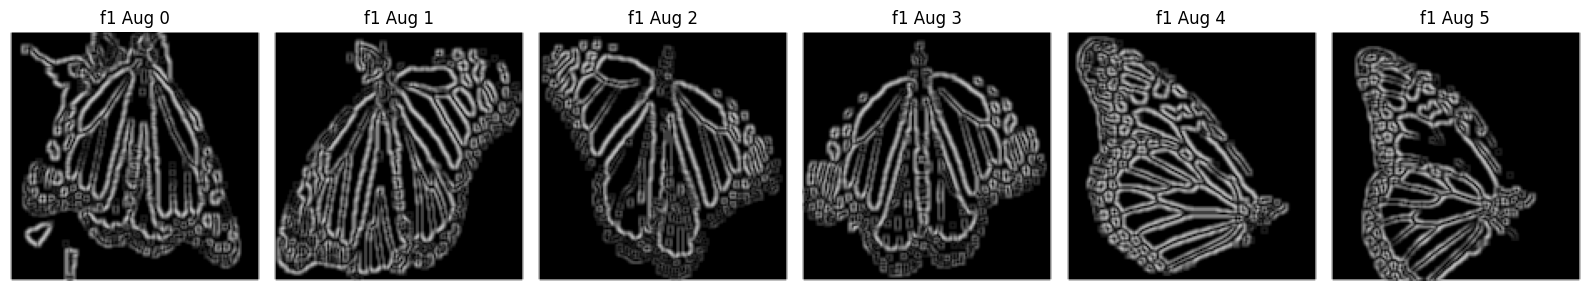

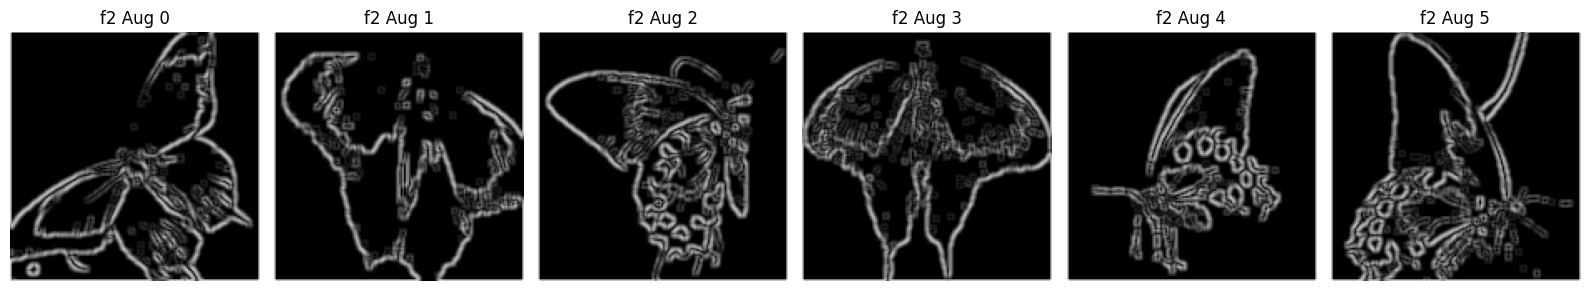

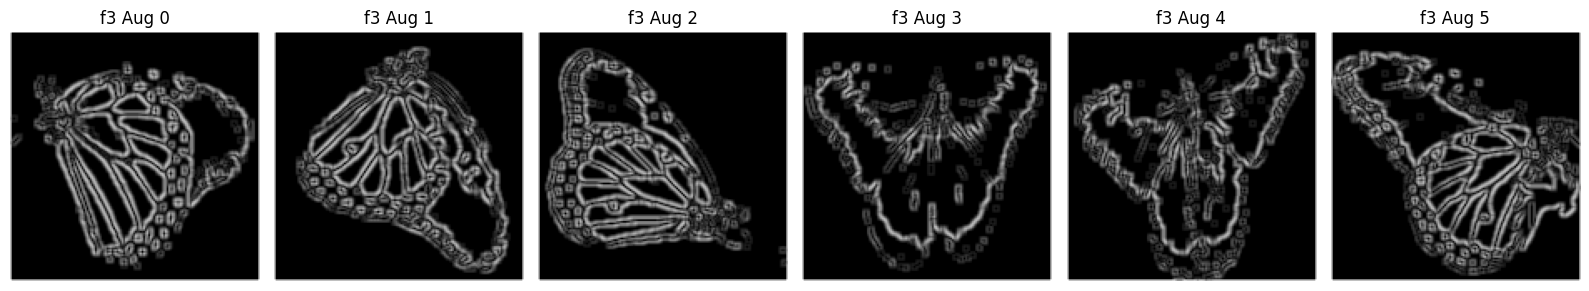

In [21]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## GLCM

In [22]:
dict_labels = {
    'monarch': 0,
    'pipevine_swallow': 1,
    'straited_queen': 2,
}

In [23]:
def contrast(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i, j] * pow(i - j, 2)
    return hasil

def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i, j] * abs(i - j)
    return hasil

def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (data[i, j] / (1 + pow(i - j, 2)))
    return hasil

def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil

def correlation(data):
    mean_x = 0
    mean_y = 0
    std_x = 0
    std_y = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean_x += i * data[i][j]
            mean_y += j * data[i][j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std_x += (i - mean_x) ** 2 * data[i][j]
            std_y += (j - mean_y) ** 2 * data[i][j]
    std_x = math.sqrt(std_x)
    std_y = math.sqrt(std_y)
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i - mean_x) * (j - mean_y) * data[i][j]
    hasil /= std_x * std_y
    return hasil

def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy

def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [24]:
def extract_glcm_features(images, labels, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    angle_labels = ['0', '45', '90', '135']
    df_data = pd.DataFrame()
    for i, image in enumerate(tqdm(images)):
        image = image.astype(int)
        glcm = graycomatrix(image, distances, angles, levels, symmetric, normed)
        for feature in features:
            for angle, angle_label in zip(angles, angle_labels):
                glcm_matrix = glcm[:, :, 0, int(angle * 4 / np.pi)]
                if feature == 'contrast':
                    feat_a = contrast(glcm_matrix)
                elif feature == 'dissimilarity':
                    feat_a = dissimilarity(glcm_matrix)
                elif feature == 'homogeneity':
                    feat_a = homogeneity(glcm_matrix)
                elif feature == 'energy':
                    feat_a = energy(glcm_matrix)
                elif feature == 'correlation':
                    feat_a = correlation(glcm_matrix)
                df_data.loc[i, f'{feature}_{angle_label}'] = feat_a
        for angle, angle_label in zip(angles, angle_labels):
            glcm_matrix = glcm[:, :, 0, int(angle * 4 / np.pi)]
            asm_value = asm(glcm_matrix)
            entropy_value = entropy(glcm_matrix)
            df_data.loc[i, f'asm_{angle_label}'] = asm_value
            df_data.loc[i, f'entropy_{angle_label}'] = entropy_value
        df_data.loc[i, 'label'] = dict_labels[labels[i]]
    return df_data

In [25]:
norm_images = norm_f1 + norm_f2 + norm_f3
norm_images = normalize_image(norm_images)
norm_labels = ['monarch'] * len(norm_f1) + ['pipevine_swallow'] * len(norm_f2) + ['straited_queen'] * len(norm_f3)

df_glcm = extract_glcm_features(norm_images, norm_labels)

100%|██████████| 300/300 [09:37<00:00,  1.93s/it]


## Seleksi Fitur

In [26]:
correlations = df_glcm.corr()['label'].abs().sort_values(ascending=False)
top_features = correlations.index[1:26]  
print("Top features based on correlation with the label:", top_features)

Top features based on correlation with the label: Index(['correlation_135', 'correlation_45', 'correlation_0', 'correlation_90',
       'asm_90', 'energy_90', 'energy_45', 'asm_45', 'asm_135', 'energy_135',
       'asm_0', 'energy_0', 'contrast_90', 'contrast_45', 'dissimilarity_90',
       'contrast_0', 'contrast_135', 'dissimilarity_45', 'entropy_45',
       'dissimilarity_0', 'entropy_90', 'entropy_135', 'entropy_0',
       'homogeneity_90', 'dissimilarity_135'],
      dtype='object')


In [54]:
x, y = df_glcm[top_features], df_glcm['label']

In [55]:
pca = PCA(n_components=25)
x_pca = pca.fit_transform(x)

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## KNN, SVM, RFC

In [57]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
knn_pred = knn_model.predict(x_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

svm_model = SVC()
svm_model.fit(x_train, y_train)
svm_pred = svm_model.predict(x_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

In [58]:
model_dict = {
    'KNN': knn_model,
    'SVM': svm_model,
    'RF': rf_model
}

df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())

In [59]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred, average='weighted')

In [60]:
print(df_eval)

     Accuracy Precision    Recall  F1 Score
KNN       0.6   0.59829       0.6  0.578843
SVM  0.666667  0.676444  0.666667  0.669848
RF   0.666667  0.671032  0.666667  0.667633


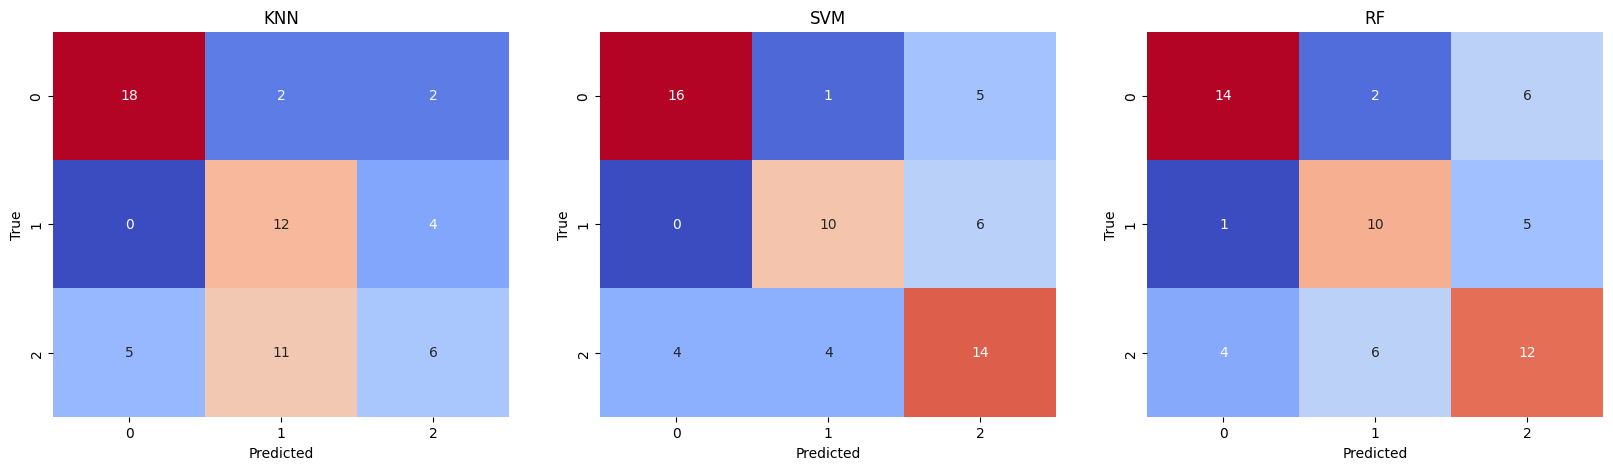

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, model_name in enumerate(model_dict.keys()):
    y_pred = model_dict[model_name].predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(model_name)
plt.show()